In [1]:
import numpy as np
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt

In [2]:
from Lu_McCartney import lu_mc_cartney

In [3]:
m = lu_mc_cartney()


## Test Brunauer-Emmett-Teller (BET) model

In [4]:
params = {}
# fitting parameters for different materials
c = {"Boom Clay": {"T": 273.15+22.0, "c": 16.0},
     "FEBEX Bentonite": {"T": 273.15+26.0, "c": 24.0},
     "MX80 Bentonite": {"T": 273.15+20.0, "c": 22.0},
     "GMZ01 Bentonite": {"T": 273.15+20.0, "c": 31.0}}
# testing psi max values at T ref defined in c
psi_max = {"Boom Clay": 727.115e6,
           "FEBEX Bentonite": 1105.454e6,
           "MX80 Bentonite": 993.009e6,
           "GMZ01 Bentonite": 1399.239e6}

In [5]:
temperature = np.linspace(273.15, 473.15, 100)  # Temperatures from 0°C to 200°C

Text(0, 0.5, 'BET Constant c')

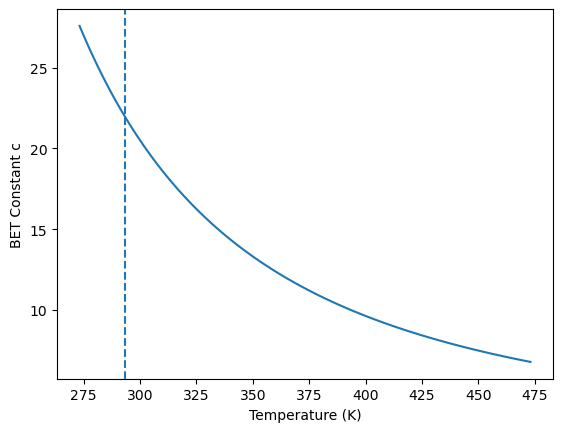

In [6]:
plt.plot(temperature, m.c(temperature))
plt.axvline(x=c['MX80 Bentonite']['T'], color='C0', linestyle='--')
plt.xlabel('Temperature (K)')
plt.ylabel('BET Constant c')

In [7]:
for entry in c:
    params[entry] = {}
    params[entry]['E1_minus_EL'] = np.log(c[entry]['c']) * m.R * c[entry]['T']

In [8]:
params

{'Boom Clay': {'E1_minus_EL': np.float64(6803.853838682097)},
 'FEBEX Bentonite': {'E1_minus_EL': np.float64(7904.547103777231)},
 'MX80 Bentonite': {'E1_minus_EL': np.float64(7533.930402019812)},
 'GMZ01 Bentonite': {'E1_minus_EL': np.float64(8369.804359014617)}}

In [9]:
for entry in params:
    m.E1_minus_EL = params[entry]['E1_minus_EL']
    print(f"maximum pressure psi_max - expected max pressure: {m.psi_max(c[entry]['T'])-psi_max[entry]:.2f} Pa for {entry}")

maximum pressure psi_max - expected max pressure: -12319.11 Pa for Boom Clay
maximum pressure psi_max - expected max pressure: -18965.33 Pa for FEBEX Bentonite
maximum pressure psi_max - expected max pressure: -17444.89 Pa for MX80 Bentonite
maximum pressure psi_max - expected max pressure: -23626.89 Pa for GMZ01 Bentonite


## Adsorption capacity

(0.5, 0.9)

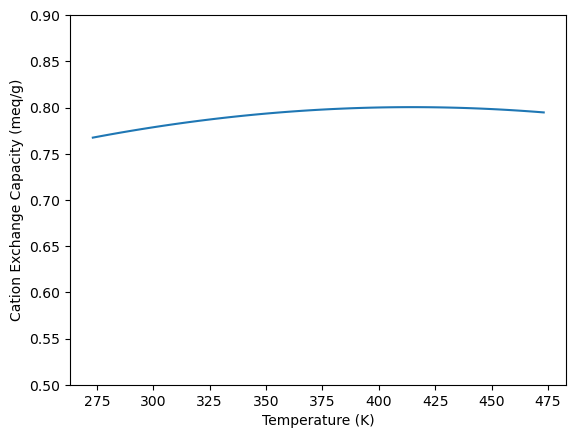

In [10]:
plt.plot(temperature, m.CEC(temperature))
plt.xlabel('Temperature (K)')
plt.ylabel('Cation Exchange Capacity (meq/g)')
plt.ylim(0.5, 0.9)

In [11]:
print(m.A, m.B, m.T1, m.T2, m.CEC_max,m.rho_d)

0.92 0.9 373.15 1273.15 0.8004082526701221 1600.0


In [12]:
# CEC values for deriving fitting parameter CEC_max:
CEC = {"Boom Clay": {"T": 273.15+22.0, "CEC": 0.246},
     "FEBEX Bentonite": {"T": 273.15+26.0, "CEC": 0.983},
     "MX80 Bentonite": {"T": 273.15+20.0, "CEC": 0.776},
     "GMZ01 Bentonite": {"T": 273.15+20.0, "CEC": 0.776}}

In [13]:
for entry in CEC:
    cos_arg = m.A * np.pi * (m.B*CEC[entry]["T"] - m.T1) / (m.T2 - m.T1)
    params[entry]["CEC_max"] = 2.0 * CEC[entry]['CEC'] / (np.cos(cos_arg) + 1)

In [14]:
params

{'Boom Clay': {'E1_minus_EL': np.float64(6803.853838682097),
  'CEC_max': np.float64(0.2534798545419938)},
 'FEBEX Bentonite': {'E1_minus_EL': np.float64(7904.547103777231),
  'CEC_max': np.float64(1.0108839312584308)},
 'MX80 Bentonite': {'E1_minus_EL': np.float64(7533.930402019812),
  'CEC_max': np.float64(0.8004082526701221)},
 'GMZ01 Bentonite': {'E1_minus_EL': np.float64(8369.804359014617),
  'CEC_max': np.float64(0.8004082526701221)}}

## calculate nu_mr

In [15]:
theta_a_max = {"Boom Clay": {"T": 273.15+22.0, "theta_a_max": 0.101},
     "FEBEX Bentonite": {"T": 273.15+26.0, "theta_a_max": 0.297},
     "MX80 Bentonite": {"T": 273.15+20.0, "theta_a_max": 0.266},
     "GMZ01 Bentonite": {"T": 273.15+20.0, "theta_a_max": 0.260}}

In [16]:
for entry in theta_a_max:
    def nu_mr_inv(nu_mr):
        T = theta_a_max[entry]['T']
        m = lu_mc_cartney(entry)
        zeta_s = (m.c(T)-1)/m.c(T) * m.CEC(m.Tr)/nu_mr
        return (1-m.theta_s) * (m.CEC(T) / zeta_s + m.bw(T)) - theta_a_max[entry]['theta_a_max']
    root_ = fsolve(nu_mr_inv, 1e-2)
    print(f"nu_mr for {entry}: {root_[0]:.6e}")
    print(f"zeta_s for {entry}: {(m.c(theta_a_max[entry]['T'])-1)/m.c(theta_a_max[entry]['T']) * m.CEC(m.Tr)/root_[0]:.6e} meq/g")

nu_mr for Boom Clay: 7.994125e-02
zeta_s for Boom Clay: 9.386575e+00 meq/g
nu_mr for FEBEX Bentonite: 3.374814e-01
zeta_s for FEBEX Bentonite: 2.219912e+00 meq/g
nu_mr for MX80 Bentonite: 2.752035e-01
zeta_s for MX80 Bentonite: 2.728759e+00 meq/g
nu_mr for GMZ01 Bentonite: 1.505956e-01
zeta_s for GMZ01 Bentonite: 4.986627e+00 meq/g


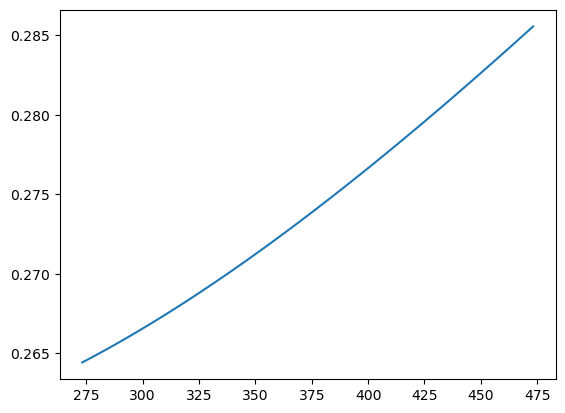

In [17]:
m = lu_mc_cartney()
plt.plot(temperature, m.theta_a_max(temperature))

# Temperature effects on capillarity

In [18]:
chi = [341.2, 340.3, 325, 317.8]
templist = [20+273.15, 22+273.15, 60+273.15, 80+273.15]

In [19]:
m = lu_mc_cartney()
for T_i in templist:
    print(f"At T={T_i-273.15:.1f}C: capillarity factor chi={m.chi(T_i):.1f}")

At T=20.0C: capillarity factor chi=341.2
At T=22.0C: capillarity factor chi=340.3
At T=60.0C: capillarity factor chi=324.9
At T=80.0C: capillarity factor chi=317.8


In [20]:
(1-m.Tr)/(1-270)

1.0860223048327138

## Fit refractive indices and dielectric constants

In [21]:
psi_c = {"Boom Clay": {"T": [273.15+22.0, 273.15+80.0], "psi_c": [7129e3, 7932e3]},
     "FEBEX Bentonite": {"T": [273.15+26.0, 273.15+80.0], "psi_c": [13615e3, 14898e3]},
     "MX80 Bentonite": {"T": [273.15+20.0, 273.15+60.0], "psi_c": [1.0213e7, 1.0857e7]},
     "GMZ01 Bentonite": {"T": [273.15+20.0, 273.15+80.0], "psi_c": [16250e3, 17961e3]}}

In [22]:
def hamaker_constant(T, eps_s, n_s, material="MX80 Bentonite"):
    m = lu_mc_cartney(material)
    dielectric_term = ((eps_s - m.epsilon_w(T))/(eps_s + m.epsilon_w(T)))**2
    RI_term = (n_s**2 - m.n_w**2)**2 / (n_s**2 + m.n_w**2)**(3/2)
    prefactor_dielectic = (3 * m.kB * T)/4
    prefactor_RI = (3 * m.hp * m.nu_e)/ (16 * np.sqrt(2))
    A_H = prefactor_dielectic * dielectric_term + prefactor_RI * RI_term
    return A_H

def psi_c_calc(T, eps_s, n_s, material="MX80 Bentonite"):
    m = lu_mc_cartney(material)
    A_H = hamaker_constant(T, eps_s, n_s, material)
    psi_c = A_H / (6 * np.pi) * (m.theta_a_max(T) / ( m.SSA * m.rho_d))**(-3.0)  # Convert from F/m to C^2/(J·m)
    return psi_c

(1e-21, 5e-21)

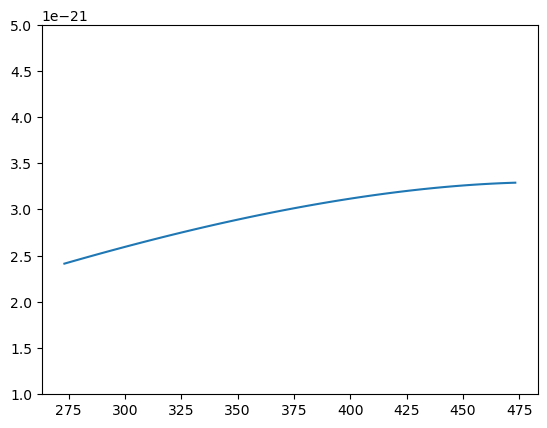

In [23]:
plt.plot(temperature, [hamaker_constant(T_i, 3.5, 1.55, "MX80 Bentonite") for T_i in temperature])
plt.ylim(1e-21, 5e-21)

(0.0, 40000.0)

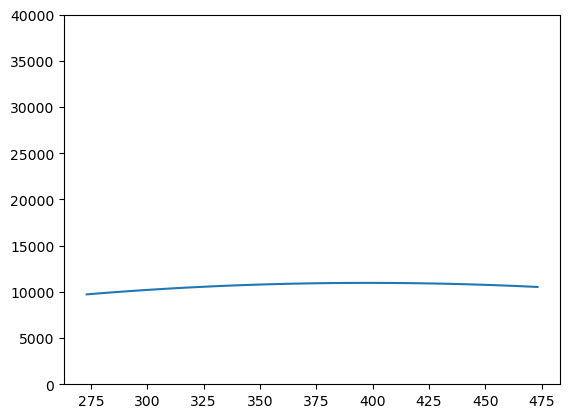

In [24]:
plt.plot(temperature, [psi_c_calc(T_i, 3.5, 1.55, "MX80 Bentonite")/1e3 for T_i in temperature])
plt.ylim(0, 4e4)

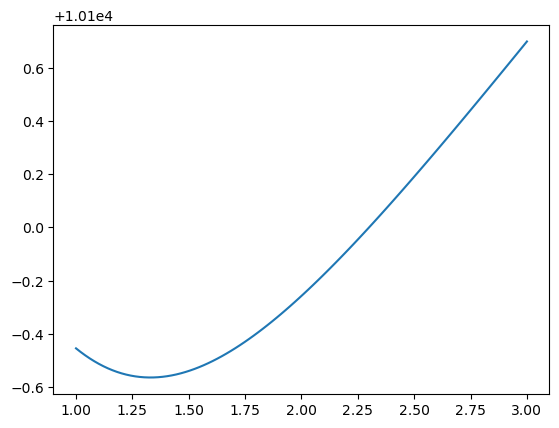

In [25]:
n_var = np.linspace(1, 3, 100)
plt.plot(n_var, [psi_c_calc(293.15, 3.5, n_i, "MX80 Bentonite")/1e3 for n_i in n_var])

Boom Clay  message: The relative error between two consecutive iterates is at most 0.000000
 success: True
  status: 2
     fun: [ 0.000e+00  0.000e+00]
       x: [ 1.327e+00 -3.544e+01]
   cov_x: [[ 5.872e-11 -4.880e-08]
           [-4.880e-08  4.236e-05]]
  method: lm
    nfev: 18
    fjac: [[ 6.299e+05  8.238e-01]
           [ 7.255e+02 -1.536e+02]]
    ipvt: [0 1]
     qtf: [-9.096e-08  4.247e-07]
FEBEX Bentonite  message: The relative error between two consecutive iterates is at most 0.000000
 success: True
  status: 2
     fun: [-1.863e-09  3.725e-09]
       x: [ 9.404e-01  7.488e+02]
   cov_x: [[ 2.001e-11  1.730e-08]
           [ 1.730e-08  1.556e-05]]
  method: lm
    nfev: 18
    fjac: [[ 1.143e+06  8.162e-01]
           [-1.271e+03  2.535e+02]]
    ipvt: [0 1]
     qtf: [-9.214e-07 -2.232e-07]
MX80 Bentonite  message: Both actual and predicted relative reductions in the sum of squares
            are at most 0.000000
 success: True
  status: 1
     fun: [ 3.397e+04 -2.671e+0

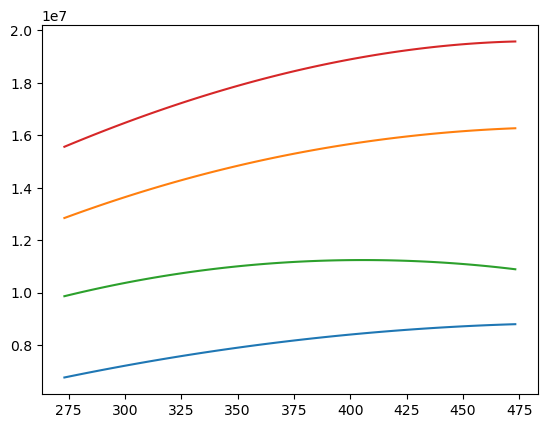

In [26]:
eps_s = {}
RI_s = {}
for entry in psi_c:
    def A_H(x):
        m = lu_mc_cartney(entry)
        psi_c_0 = psi_c_calc(psi_c[entry]["T"][0], x[0], x[1], entry)
        psi_c_1 = psi_c_calc(psi_c[entry]["T"][1], x[0], x[1], entry)
        psi_c_0 -= psi_c[entry]["psi_c"][0]
        psi_c_1 -= psi_c[entry]["psi_c"][1]
        return [psi_c_0, psi_c_1]
    root_ = root(A_H, [3.5, 1.55], method='lm')
    print(entry, root_)
    eps_s[entry] = root_.x[0]
    RI_s[entry] = np.abs(root_.x[1])
    plt.plot(temperature, [psi_c_calc(T_i, eps_s[entry], RI_s[entry], entry) for T_i in temperature])
        # print(f"eps_s for {entry}: {root_[0]:.6e} RI_s {root_[1]:.6e}")
        #A_H([3.5, 1.55])

In [27]:
eps_s, RI_s

({'Boom Clay': np.float64(1.3267932723717908),
  'FEBEX Bentonite': np.float64(0.940367803768519),
  'MX80 Bentonite': np.float64(3.208925112257479),
  'GMZ01 Bentonite': np.float64(2.1590265530454893)},
 {'Boom Clay': np.float64(35.435652398543425),
  'FEBEX Bentonite': np.float64(748.7804881357005),
  'MX80 Bentonite': np.float64(1.3298392371979677),
  'GMZ01 Bentonite': np.float64(2175.885110079861)})

(1e-21, 5e-21)

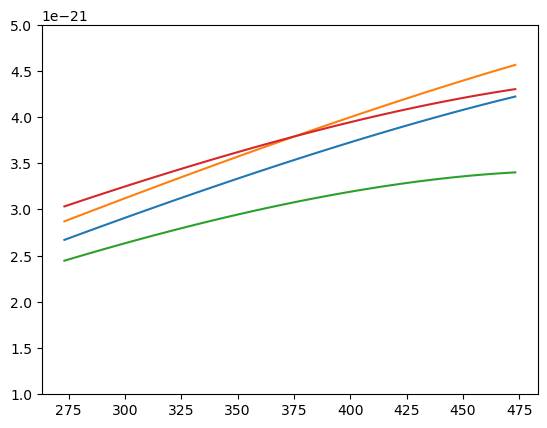

In [28]:
for entry in eps_s:
    plt.plot(temperature, [hamaker_constant(T_i, eps_s[entry], RI_s[entry], entry) for T_i in temperature])
plt.ylim(1e-21, 5e-21)

## Psi_aev

Text(0, 0.5, 'Inverse alpha (kPa)')

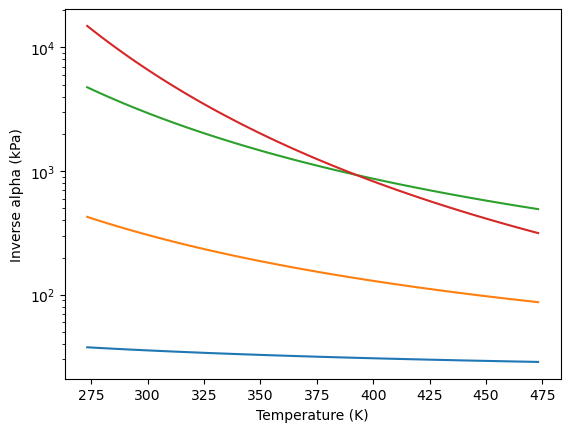

In [29]:
for entry in RI_s:
    m = lu_mc_cartney(entry)
    plt.plot(temperature, [1/m.alpha(T_i)/1e3 for T_i in temperature])
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Inverse alpha (kPa)')

## Full WRC

In [38]:
p = np.logspace(3, 10, 100)

In [39]:
p

array([1.00000000e+03, 1.17681195e+03, 1.38488637e+03, 1.62975083e+03,
       1.91791026e+03, 2.25701972e+03, 2.65608778e+03, 3.12571585e+03,
       3.67837977e+03, 4.32876128e+03, 5.09413801e+03, 5.99484250e+03,
       7.05480231e+03, 8.30217568e+03, 9.77009957e+03, 1.14975700e+04,
       1.35304777e+04, 1.59228279e+04, 1.87381742e+04, 2.20513074e+04,
       2.59502421e+04, 3.05385551e+04, 3.59381366e+04, 4.22924287e+04,
       4.97702356e+04, 5.85702082e+04, 6.89261210e+04, 8.11130831e+04,
       9.54548457e+04, 1.12332403e+05, 1.32194115e+05, 1.55567614e+05,
       1.83073828e+05, 2.15443469e+05, 2.53536449e+05, 2.98364724e+05,
       3.51119173e+05, 4.13201240e+05, 4.86260158e+05, 5.72236766e+05,
       6.73415066e+05, 7.92482898e+05, 9.32603347e+05, 1.09749877e+06,
       1.29154967e+06, 1.51991108e+06, 1.78864953e+06, 2.10490414e+06,
       2.47707636e+06, 2.91505306e+06, 3.43046929e+06, 4.03701726e+06,
       4.75081016e+06, 5.59081018e+06, 6.57933225e+06, 7.74263683e+06,
      

735966252.343669
727102680.8888888
598201583.1740261
551762431.0812427


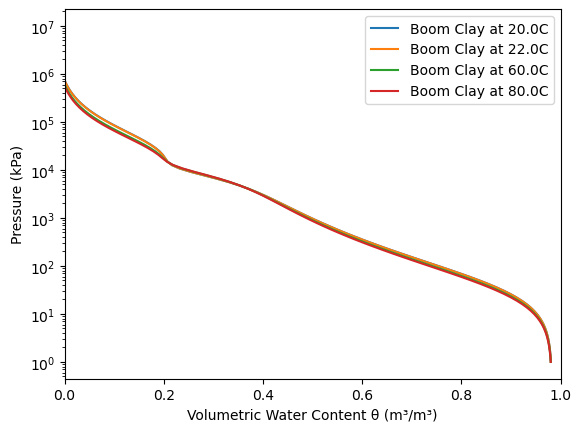

1156067960.7107403
1138655170.4740114
890071747.4140645
802705017.7317907


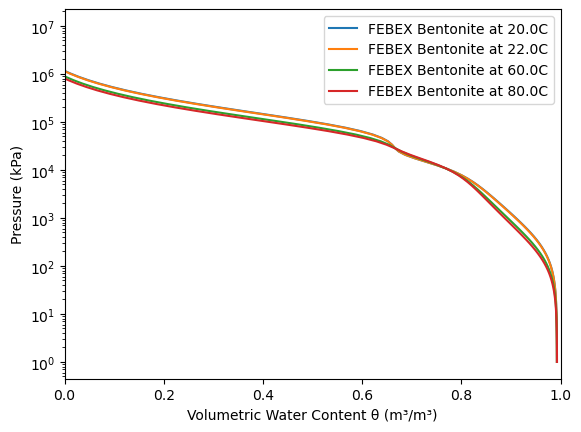

992991555.1111113
979043297.8218584
778603055.6525613
707518755.33374


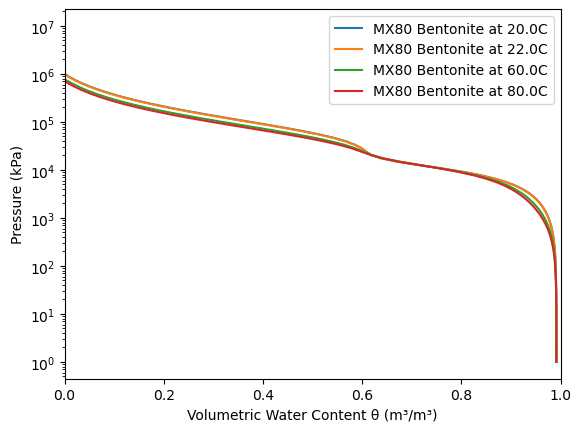

1399215373.1111112
1376358815.7048545
1052864784.2800894
940529256.8658787


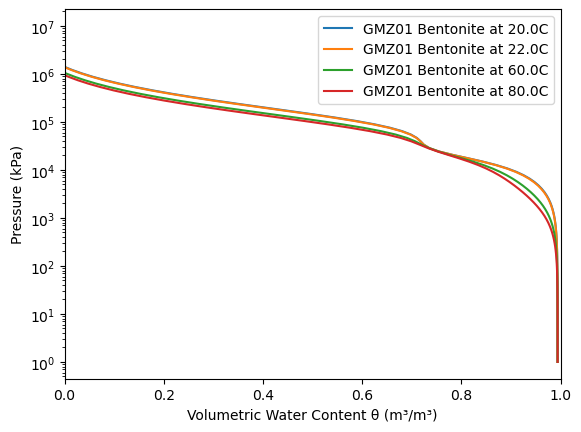

In [40]:
for entry in eps_s:
    for T_i in templist:
        m = lu_mc_cartney(entry)
        print(m.psi_max(T_i))
        plt.plot([m.water_content(p_i, T_i)/m.phi for p_i in p], p/1000, label=f"{entry} at {T_i-273.15:.1f}C")
        #plt.plot([m.adsorptive_water_content(p_i, T_i)/m.phi for p_i in p], p/1000, '--', label=f"{entry} at {T_i-273.15:.1f}C")
        #plt.plot([m.capillary_water_content(p_i, T_i)/m.phi for p_i in p], p/1000, '-.', label=f"{entry} at {T_i-273.15:.1f}C")
    plt.yscale('log')
    plt.ylabel('Pressure (kPa)')
    plt.xlabel('Volumetric Water Content θ (m³/m³)')
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

In [33]:
eps_s

{'Boom Clay': np.float64(1.3267932723717908),
 'FEBEX Bentonite': np.float64(0.940367803768519),
 'MX80 Bentonite': np.float64(3.208925112257479),
 'GMZ01 Bentonite': np.float64(2.1590265530454893)}

In [34]:
for entry in eps_s:
    m = lu_mc_cartney(entry)
    for T_i in templist:
        print("T=", T_i-273.15, m.chi(T_i))

T= 20.0 341.18338579578386
T= 22.0 340.3
T= 60.0 324.9459253807276
T= 80.0 317.8056324350371
T= 20.0 341.18338579578386
T= 22.0 340.3
T= 60.0 324.9459253807276
T= 80.0 317.8056324350371
T= 20.0 341.18338579578386
T= 22.0 340.3
T= 60.0 324.9459253807276
T= 80.0 317.8056324350371
T= 20.0 341.18338579578386
T= 22.0 340.3
T= 60.0 324.9459253807276
T= 80.0 317.8056324350371


In [35]:
340.8326409953732/340.3

1.0015652100951313

In [36]:
-0.516/1.0015652100951313

-0.5151936137548038

In [37]:
1/0.028

35.714285714285715